# CNN for Trading - Part 1: Feature Engineering

To exploit the grid-like structure of time-series data, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

An alternative approach converts a time series of alpha factors into a two-dimensional format to leverage the ability of CNNs to detect local patterns. [Sezer and Ozbayoglu (2018)](https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach) propose CNN-TA, which computes 15 technical indicators for different intervals and uses hierarchical clustering (see Chapter 13, Data-Driven Risk Factors and Asset Allocation with Unsupervised Learning) to locate indicators that behave similarly close to each other in a two-dimensional grid.

The authors train a CNN similar to the CIFAR-10 example we used earlier to predict whether to buy, hold, or sell an asset on a given day. They compare the CNN performance to "buy-and-hold" and other models and find that it outperforms all alternatives using daily price series for Dow 30 stocks and the nine most-traded ETFs over the 2007-2017 time period.

The section on *CNN for Trading* consists of three notebooks that experiment with this approach using daily US equity price data. They demonstrate 
1. How to compute relevant financial features
2. How to convert a similar set of indicators into image format and cluster them by similarity
3. How to train a CNN to predict daily returns and evaluate a simple long-short strategy based on the resulting signals.

## Creating technical indicators at different intervals
We first select a universe of the 500 most-traded US stocks from the Quandl Wiki dataset by dollar volume for rolling five-year periods for 2007-2017. 

- Our features consist of 15 technical indicators and risk factors that we compute for 15 different intervals and then arrange them in a 15x15 grid.
- For each indicator, we vary the time period from 6 to 20 to obtain 15 distinct measurements. 

## Imports & Settings

To install `talib` with Python 3.7 follow [these](https://medium.com/@joelzhang/install-ta-lib-in-python-3-7-51219acacafb) instructions.

In [1]:
import warnings

from tqdm import tqdm

from data.data_loader import data_loader

warnings.filterwarnings('ignore')

In [2]:
from talib import (RSI, BBANDS, MACD,
                   NATR, WILLR, WMA,
                   EMA, SMA, CCI, CMO,
                   MACD, PPO, ROC,
                   ADOSC, ADX, MOM)
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

In [3]:
DATA_STORE = '../data/assets.h5'

In [4]:
MONTH = 21
YEAR = 12 * MONTH

In [5]:
START = '2000-01-01'
END = '2021-05-28'

In [6]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [7]:
T = [1, 5, 10, 21, 42, 63]
percentiles = [0, 0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 0.99, 0.999]

In [8]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Loading Quandl Wiki Stock Prices & Meta Data

In [9]:
adj_ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [10]:
"""
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], adj_ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index()
             .dropna())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])
ohlcv = prices.columns.tolist()
"""

"\nwith pd.HDFStore(DATA_STORE) as store:\n    prices = (store['quandl/wiki/prices']\n              .loc[idx[START:END, :], adj_ohlcv]\n              .rename(columns=lambda x: x.replace('adj_', ''))\n              .swaplevel()\n              .sort_index()\n             .dropna())\n    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])\nohlcv = prices.columns.tolist()\n"

In [11]:
"""
prices.volume /= 1e3
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'
"""


## Loading Crypto Prices & Meta Data


"\nprices.volume /= 1e3\nprices.index.names = ['symbol', 'date']\nmetadata.index.name = 'symbol'\n"

In [12]:

downsampleshift = False
minutes_per_base_frequency = 60
prices, metadata, categories = data_loader(timeframe='H',
                                           minutes_per_base_frequency=minutes_per_base_frequency,  # 5 Minutes sampled input data in data path
                                            prices_path='../data/crypto/prices_H.ftr',
                                            min_observation_years=1,
                                            drop_level=True,
                                            exclude_stablecoins=True,
                                            cut=False,
                                            n_min_tickers=0,
                                            reduce_size=True,
                                            downsampleshift=downsampleshift,
                                            d_shift=60,
                                            join_sector=False,
                                            join_sectors=False)
prices = (prices.loc[idx[START:END, :], :]
                .swaplevel()
              .sort_index())
ohlcv = prices.columns.tolist()
print(ohlcv)
print('prices dates {}:{}'.format(prices.index.get_level_values('date').min(),
                                 prices.index.get_level_values('date').max()))


reducing footprint

['open', 'high', 'low', 'close', 'volume']
prices dates 2013-04-01 01:00:00:2021-05-28 23:00:00


In [13]:
if downsampleshift:
    glevel= ['ticker', 'offset'] # no downsampleshift
else:
    glevel= 'ticker' # no downsampleshift



<AxesSubplot:xlabel='date'>

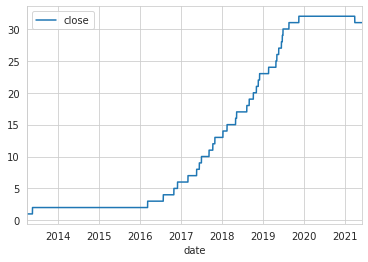

In [14]:
cols=['close']
prices[cols].groupby('date').count().plot()

## Rolling universe: pick 500 most-traded stocks

In [15]:
#dollar_vol = prices.volume.unstack(glevel).sort_index()

In [16]:
years = sorted(np.unique([d.year for d in prices.index.get_level_values('date').unique()]))
years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [17]:
prices.info(null_counts=True)

"""
train_window = 2 # years
universe_size = 25


universe = []
for i, year in enumerate(years[5:], 5):
    start = str(years[i-5])
    end = str(years[i])
    most_traded = (dollar_vol.loc[start:end, :]
                   .dropna(thresh=1000, axis=1)
                   .median()
                   .nlargest(universe_size)
                   .index)
    universe.append(prices.loc[idx[most_traded, start:end], :])
universe = pd.concat(universe)
"""
universe = prices

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 949852 entries, ('algo-usd', Timestamp('2019-06-21 10:00:00', freq='H')) to ('zec-usd', Timestamp('2021-05-28 23:00:00', freq='H'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    949852 non-null  float32
 1   high    949852 non-null  float32
 2   low     949852 non-null  float32
 3   close   949852 non-null  float32
 4   volume  949852 non-null  float64
dtypes: float32(4), float64(1)
memory usage: 28.8 MB


In [18]:
universe = universe.loc[~universe.index.duplicated()]

In [19]:
universe.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 949852 entries, ('algo-usd', Timestamp('2019-06-21 10:00:00', freq='H')) to ('zec-usd', Timestamp('2021-05-28 23:00:00', freq='H'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    949852 non-null  float32
 1   high    949852 non-null  float32
 2   low     949852 non-null  float32
 3   close   949852 non-null  float32
 4   volume  949852 non-null  float64
dtypes: float32(4), float64(1)
memory usage: 28.8 MB


In [20]:
glevel
universe.groupby(glevel).size().describe()

count       32.000000
mean     29682.875000
std      13852.927481
min      13452.000000
25%      19517.500000
50%      26854.000000
75%      34853.250000
max      71519.000000
dtype: float64

In [21]:
universe.reset_index().to_feather('universe.ftr')
universe_index = ['date', 'ticker']

## Generate Technical Indicators Factors

In [22]:
T = list(range(6, 21))

### Relative Strength Index

In [23]:
for t in tqdm(T):
    universe[f'{t:02}_RSI'] = universe.groupby(glevel).close.apply(RSI, timeperiod=t)

universe.info()

100%|██████████| 15/15 [00:02<00:00,  5.40it/s]


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 949852 entries, ('algo-usd', Timestamp('2019-06-21 10:00:00', freq='H')) to ('zec-usd', Timestamp('2021-05-28 23:00:00', freq='H'))
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    949852 non-null  float32
 1   high    949852 non-null  float32
 2   low     949852 non-null  float32
 3   close   949852 non-null  float32
 4   volume  949852 non-null  float64
 5   06_RSI  949660 non-null  float64
 6   07_RSI  949628 non-null  float64
 7   08_RSI  949596 non-null  float64
 8   09_RSI  949564 non-null  float64
 9   10_RSI  949532 non-null  float64
 10  11_RSI  949500 non-null  float64
 11  12_RSI  949468 non-null  float64
 12  13_RSI  949436 non-null  float64
 13  14_RSI  949404 non-null  float64
 14  15_RSI  949372 non-null  float64
 15  16_RSI  949340 non-null  float64
 16  17_RSI  949308 non-null  float64
 17  18_RSI  949276 non-null  float64
 18  19_RSI  949244 non-n

### Williams %R

In [24]:
for t in tqdm(T):
    universe[f'{t:02}_WILLR'] = (universe.groupby(glevel, group_keys=False)
     .apply(lambda x: WILLR(x.high, x.low, x.close, timeperiod=t)))

100%|██████████| 15/15 [00:02<00:00,  5.71it/s]


### Compute Bollinger Bands

In [25]:
def compute_bb(close, timeperiod):
    high, mid, low = BBANDS(close, timeperiod=timeperiod)
    return pd.DataFrame({f'{timeperiod:02}_BBH': high, f'{timeperiod:02}_BBL': low}, index=close.index)

In [26]:
for t in tqdm(T):
    bbh, bbl = f'{t:02}_BBH', f'{t:02}_BBL'
    universe = (universe.join(
        universe.groupby(glevel).close.apply(compute_bb,
                                                     timeperiod=t)))
    universe[bbh] = universe[bbh].sub(universe.close).div(universe[bbh]).apply(np.log1p)
    universe[bbl] = universe.close.sub(universe[bbl]).div(universe.close).apply(np.log1p)

100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


### Normalized Average True Range

In [27]:
for t in tqdm(T):
    universe[f'{t:02}_NATR'] = universe.groupby(glevel,
                                group_keys=False).apply(lambda x: 
                                                        NATR(x.high, x.low, x.close, timeperiod=t))

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


### Percentage Price Oscillator

In [28]:
for t in tqdm(T):
    universe[f'{t:02}_PPO'] = universe.groupby(glevel).close.apply(PPO, fastperiod=t, matype=1)

100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


### Moving Average Convergence/Divergence

In [29]:
def compute_macd(close, signalperiod):
    macd = MACD(close, signalperiod=signalperiod)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [30]:
for t in tqdm(T):
    universe[f'{t:02}_MACD'] = (universe
                  .groupby(glevel, group_keys=False)
                  .close
                  .apply(compute_macd, signalperiod=t))

100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


### Momentum

In [31]:
for t in tqdm(T):
    universe[f'{t:02}_MOM'] = universe.groupby(glevel).close.apply(MOM, timeperiod=t)

100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


### Weighted Moving Average

In [32]:
for t in tqdm(T):
    universe[f'{t:02}_WMA'] = universe.groupby(glevel).close.apply(WMA, timeperiod=t)

100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


### Exponential Moving Average

In [33]:
for t in tqdm(T):
    universe[f'{t:02}_EMA'] = universe.groupby(glevel).close.apply(EMA, timeperiod=t)

100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


### Commodity Channel Index

In [34]:
for t in tqdm(T):
    universe[f'{t:02}_CCI'] = (universe.groupby(glevel, group_keys=False)
     .apply(lambda x: CCI(x.high, x.low, x.close, timeperiod=t)))

100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


### Chande Momentum Oscillator

In [35]:
for t in tqdm(T):
    universe[f'{t:02}_CMO'] = universe.groupby(glevel).close.apply(CMO, timeperiod=t)

100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


### Rate of Change

Rate of change is a technical indicator that illustrates the speed of price change over a period of time.

In [36]:
for t in tqdm(T):
    universe[f'{t:02}_ROC'] = universe.groupby(glevel).close.apply(ROC, timeperiod=t)

100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


### Chaikin A/D Oscillator

In [37]:
for t in tqdm(T):
    universe[f'{t:02}_ADOSC'] = (universe.groupby(glevel, group_keys=False)
     .apply(lambda x: ADOSC(x.high, x.low, x.close, x.volume, fastperiod=t-3, slowperiod=4+t)))

100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


### Average Directional Movement Index

In [38]:
for t in tqdm(T):
    universe[f'{t:02}_ADX'] = universe.groupby(glevel,
                                group_keys=False).apply(lambda x: 
                                                        ADX(x.high, x.low, x.close, timeperiod=t))

100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


In [39]:
temp = universe.drop(ohlcv, axis=1)
temp.reset_index().to_feather('features.ftr')
temp = None

## Compute Historical Returns

### Historical Returns

In [40]:
by_sym = universe.groupby(glevel).close
for t in tqdm([12, 24]):
    universe[f'r{t:02}'] = by_sym.pct_change(t)

100%|██████████| 2/2 [00:00<00:00, 89.51it/s]


### Remove outliers

In [41]:
universe[[f'r{t:02}' for t in [12, 24]]].describe(percentiles=percentiles)

,r12,r24
count,949468.000000,949084.000000
mean,0.002155,0.004157
std,0.107367,0.120874
min,-0.988839,-0.988828
0%,-0.988839,-0.988828
0.1%,-0.296299,-0.365902
1%,-0.137591,-0.185911
20%,-0.022882,-0.034496
40%,-0.003602,-0.006192
50%,0.000000,0.000000


In [42]:
#outliers = universe[universe.r01>1].index.get_level_values('ticker').unique()
#len(outliers)

In [43]:
#universe = universe.drop(outliers, 'ticker')

### Historical return quantiles

In [44]:
for t in tqdm([12, 24]):
    universe[f'r{t:02}dec'] = (universe[f'r{t:02}'].groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=3, labels=False, duplicates='drop')))

100%|██████████| 2/2 [01:48<00:00, 54.42s/it]


## Rolling Factor Betas

We also use five Fama-French risk factors (Fama and French, 2015; see Chapter 4, Financial Feature Engineering – How to Research Alpha Factors). They reflect the sensitivity of a stock's returns to factors consistently demonstrated to impact equity returns. 

We capture these factors by computing the coefficients of a rolling OLS regression of a stock's daily returns on the returns of portfolios designed to reflect the underlying drivers:
- **Equity risk premium**: Value-weighted returns of US stocks minus the 1-month US
- **Treasury bill rate**
- **Size (SMB)**: Returns of stocks categorized as Small (by market cap) Minus those of Big equities
- **Value (HML)**: Returns of stocks with High book-to-market value Minus those with a Low value
- **Investment (CMA)**: Returns differences for companies with Conservative investment expenditures Minus those with Aggressive spending
- **Profitability (RMW)**: Similarly, return differences for stocks with Robust profitability Minus that with a Weak metric.



In [45]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=START)[0].rename(columns={'Mkt-RF': 'Market'}))
factor_data.index.names = ['date']

In [46]:
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5386 entries, 2000-01-03 to 2021-05-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Market  5386 non-null   float64
 1   SMB     5386 non-null   float64
 2   HML     5386 non-null   float64
 3   RMW     5386 non-null   float64
 4   CMA     5386 non-null   float64
 5   RF      5386 non-null   float64
dtypes: float64(6)
memory usage: 294.5 KB


In [47]:
windows = list(range(15, 90, 5))
len(windows)

15

Next, we apply `statsmodels`' `RollingOLS()` to run regressions over windowed periods of different lengths, ranging from 15 to 90 days. We set the `params_only` parameter on the `.fit()` method to speed up computation and capture the coefficients using the `.params` attribute of the fitted factor_model:

TODO: Check POINT IN TIME for fama-french data: lookahead bias??

In [48]:
t = 24
ret = f'r{t:02}'
factors = ['Market', 'SMB', 'HML', 'RMW', 'CMA']
windows = list(range(15, 90, 5))
for window in windows:
    print(window)
    betas = []
    for ticker, data in universe.groupby(glevel):
        model_data = data[[ret]].merge(factor_data, on='date', how='left').ffill()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.drop('const', axis=1)
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True)
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{window:02}_{x}')
    universe = universe.join(betas)

15
20
25
30
35
40
45
50
55
60
65
70
75
80
85


## Compute Forward Returns

In [49]:
for t in tqdm([12, 24]):
    universe[f'r{t:02}_fwd'] = universe.groupby(glevel)[f'r{t:02}'].shift(-t)
    universe[f'r{t:02}dec_fwd'] = universe.groupby(glevel)[f'r{t:02}dec'].shift(-t)

100%|██████████| 2/2 [00:00<00:00, 48.61it/s]


## Store Model Data

In [50]:
universe = universe.drop(ohlcv, axis=1)

In [51]:
universe.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 949852 entries, ('algo-usd', Timestamp('2019-06-21 10:00:00')) to ('zec-usd', Timestamp('2021-05-28 23:00:00'))
Columns: 308 entries, 06_RSI to r24dec_fwd
dtypes: float32(4), float64(304)
memory usage: 2.2 GB


In [52]:
drop_cols = ['r12', 'r12dec', 'r24',  'r24dec']

In [53]:
outcomes = universe.filter(like='_fwd').columns

In [54]:
universe = universe.sort_index()
universe.drop(drop_cols, axis=1).drop(outcomes, axis=1).loc[idx[:, '2001':], :].reset_index().to_feather('features.ftr')
universe[outcomes].reset_index().to_feather('targets.ftr')